In [71]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from collections import OrderedDict


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


%matplotlib widget

layer class

In [72]:
class Layer():
    def __init__(self, i, errors):
        self.layers = i
        self.errs = errors
        
    
    def forward(self, A):
        for layer in self.layers:
            A = layer.forward(A)
        return A
    
    def backward(self):
        self.grad = self.errs.backward()
        i = len(self.layers) - 1
        
        while i >= 0:
            self.grad = self.layers[i].backward(self.grad)
            i -= 1
        
    def _errs(self, A, b):
        return self.errs.forward(self.forward(A), b)

Linear class


In [73]:
class Linear(Layer):
    def __init__(self, A, b):
        self.w = np.random.rand(A, b) * 0.001
        self.b = np.zeros(b)
    
    def forward(self, A):
        self.A = A
        self.b = (A @ self.w) + self.b
        
        return self.b
    
    def backward(self, grad_X):
        self.dw = np.matmulmatmul(self.A[:,:,None], grad_X[:,None,:]).mean(axis=0)
        self.db = grad_X.mean(axis=0)
        
        return grad_X @ self.w.T
    
    def update_w_b(self, lr = 0.001):
        self.w -= lr * self.dw
        self.b -= lr * self.db

Sigmoid Function


In [74]:
class Logistic_Sigmoid(Layer):
    def __init__(self):
        self.b = None
    
    def forward(self, A):
        self.b = 1.0 / (1.0 + np.exp(-A))
        return self.b
    
    def backward(self, grad_X):
        return self.b * (1 - self.b) * grad_X

hyperbolic tangent function

In [75]:
class Hyperbolic_Tangent(Layer):
    def __init__(self):
        self.b = None
    
    def forward(self, A):
        self.b = np.tanh(A)
        return self.b
    
    def backward(self, grad_X):
        return (1 - np.square(self.outputs)) * grad_X

Softmax

In [76]:
class Softmax(Layer):
    def __init__(self):
        self.num = None
        self.dm = None
        self.b = None
    
    def forward(self, A):
        self.num = np.exp(A - np.max(A))
        return self.num / np.sum(self.num, axis=0, keepdims=True)
    
    def backward(self, probs, bp_err):
        self.dm = probs.shape[1]
        self.b = np.empty(probs.shape)
        
        for j in range(self.dm):
            d_prob_over_xj = - (probs * probs[:,[j]])  
            d_prob_over_xj[:,j] += probs[:,j]  
            self.b[:,j] = np.sum(bp_err * d_prob_over_xj, axis=1)
        return self.b

Cross-Entropy Loss

In [77]:
class Cross_Entropy_Loss(Layer):
    def __init__(self):
        pass
    
    def forward(self, b):
        return -b * np.log(self.b)

    def backward(self, b):
        return b - self.b

Sequential Class

In [78]:
class Sequential(Layer):
    def __init__(self, A, b):
        self.A = A
        self.b = b
        
        self.w = None
        self.b = None
        
        self.layers = [Linear(A, b), Logistic_Sigmoid(), Linear(A, b), Logistic_Sigmoid()]
        self.model = Layer(self.layers, Cross_Entropy_Loss())
        
    def test(self, A):
        b = self.model.forward(A)
        return 1 if (np.squeeze(b) > 0.5).all() else 0
    
    def train(self, ittr = 100):
        for i in range(ittr):
            err = self.model._errs(self.A, self.b).sum()
            
            print(f"Loss in {i}th epoch: {err}")
            
            self.model.backward()
            
            for layer in self.model.layers:
                if isinstance(layer, Linear):
                    layer.update_w_b()
    

    def get_w(self):
        self.w = []
        self.b = []
        
        for layer in self.model.layers:
            if isinstance(layer, Linear):
                self.w.append(layer.w)
                self.b.append(layer.b)
        return self.w

    def s_model(self, w="model.w"):
        model_file = open(w, mode="wb")
        np.load(self.get_w(), model_file)
        model_file.close()

    def l_model(self, w="model.w"):
        model_file = open(w, mode="rb")
        w = np.load(model_file)
        model_file.close()
        return w

XOR problem

In [79]:
def calc_decision_boundary(weights):
    x = -weights[0] / weights[1]
    y = -weights[0] / weights[2]
    m = -y / x
    return np.array([m, y])

def gen_boundary_points(weights, m, b):
    # If the slope is undefined, it is vertical.
    if weights[2] != 0:
        x = np.linspace(-5, 5, 100)
        y = m * x + b
    else:
        x = np.zeros(100)
        y = np.linspace(-5, 5, 100) + b
        
    return x, y

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))
def hyperbolic(x):
     return  np.tanh(x)

def dot(w, x):
    x_bias = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
    return w @ x_bias.T

XOR inputs

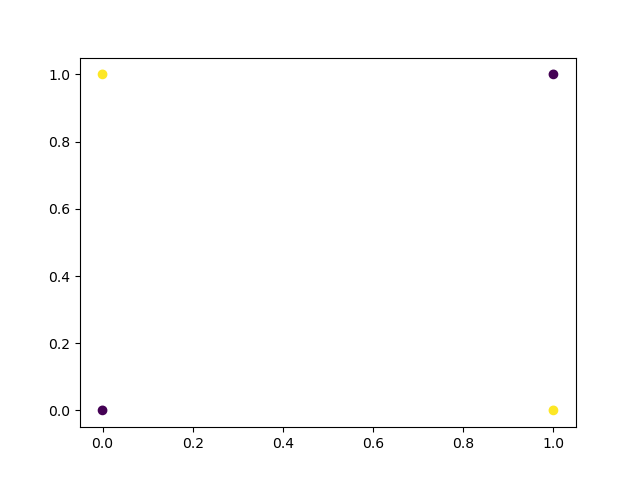

In [80]:
samples = np.array([[0, 0],
                    [0, 1],
                    [1, 0],
                    [1, 1]])
targets = np.array([0, 1, 1, 0])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(samples[:, 0], samples[:, 1], c=targets)

classifiers parameter

(-0.2, 1.2)

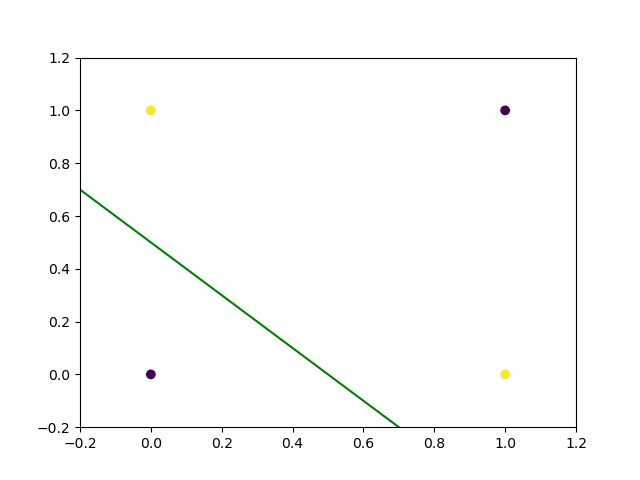

In [81]:
weights = np.array([-0.5, 1, 1]) 

# For visualizing the line
m, b = calc_decision_boundary(weights)

x, y = gen_boundary_points(weights, m, b)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y, c='g')
ax.scatter(samples[:, 0], samples[:, 1], c=targets)
ax.set_xlim([-0.2, 1.2])
ax.set_ylim([-0.2, 1.2])

Adding another Perceptron to make multi-perceptron

(-0.2, 1.2)

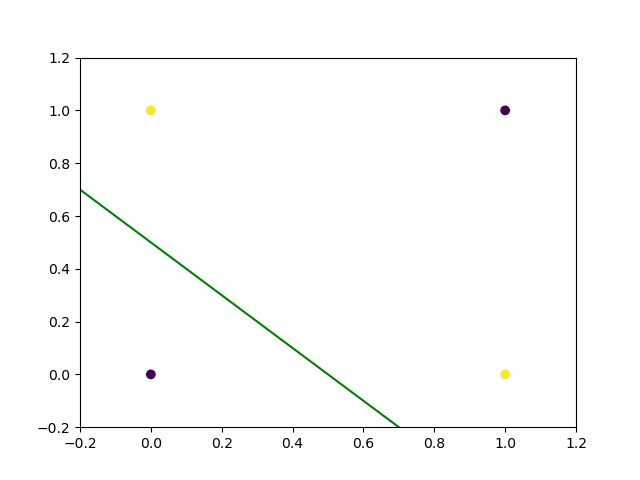

In [82]:
hidden_weights = np.array([-0.5, 1, 1])
out_weights = np.array([0, 1])

# For visualizing the line
hidden_m, hidden_b = calc_decision_boundary(hidden_weights)

hidden_x, hidden_y = gen_boundary_points(hidden_weights, hidden_m, hidden_b)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(hidden_x, hidden_y, c='g')
ax.scatter(samples[:, 0], samples[:, 1], c=targets)
ax.set_xlim([-0.2, 1.2])
ax.set_ylim([-0.2, 1.2])

For different decision boundaries 

Hidden layer AFTER non-linearity
[[0.37754067 0.62245933 0.62245933 0.81757448]
 [0.18242552 0.37754067 0.37754067 0.62245933]]
[[-0.46211716  0.46211716  0.46211716  0.90514825]
 [-0.90514825 -0.46211716 -0.46211716  0.46211716]]
Output AFTER non-linearity
(array([0.49377911, 0.50622934, 0.50622934, 0.49377911]), array([-0.02487972,  0.02491351,  0.02491351, -0.02487972]))


(-0.2, 1.2)

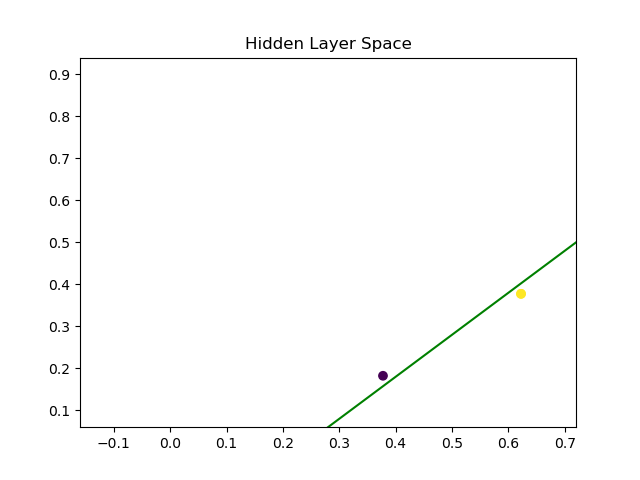

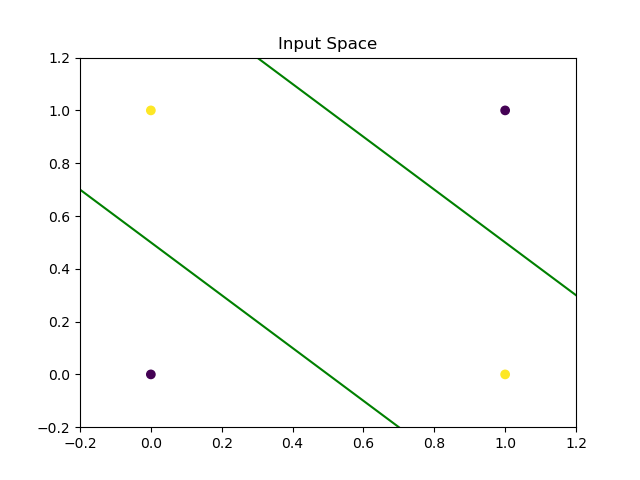

In [83]:

hidden_weights = np.array([[-0.5, 1, 1], [-1.5, 1, 1]])
out_weights = np.array([-0.22, 1.0, -1.0])

# For visualizing the line
hidden_m0, hidden_b0 = calc_decision_boundary(hidden_weights[0])
hidden_x0, hidden_y0 = gen_boundary_points(hidden_weights[0], hidden_m0, hidden_b0)
hidden_m1, hidden_b1 = calc_decision_boundary(hidden_weights[1])
hidden_x1, hidden_y1 = gen_boundary_points(hidden_weights[1], hidden_m1, hidden_b1)
out_m, out_b = calc_decision_boundary(out_weights)
out_x, out_y = gen_boundary_points(out_weights, out_m, out_b)

# Forward propagation
hidden_out = dot(hidden_weights, samples)
hidden_out2 = dot(hidden_weights,samples)
hidden_act = sigmoid(hidden_out)
hidden_act2=hyperbolic(hidden_out2)


print("Hidden layer AFTER non-linearity")
print(hidden_act)
print(hidden_act2)

c = hidden_act.mean(0)
h_min = hidden_act.min(1)
h_max = hidden_act.max(1)
b = np.abs(h_max - h_min).max()

# Visualize hidden layer space
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set_title("Hidden Layer Space")
ax1.plot(out_x, out_y, c='g')
ax1.scatter(hidden_act[0, :], hidden_act[1, :], c=targets)
ax1.set_xlim([c[0] - b, c[0] + b])
ax1.set_ylim([c[1] - b, c[1] + b])

# Forward pass finishing with final neuron
out = dot(out_weights, hidden_act.T)

out_act = sigmoid(out),hyperbolic(out)
print("Output AFTER non-linearity")
print(out_act)    
    
# Visualize input space
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.set_title("Input Space")
ax2.plot(hidden_x0, hidden_y0, c='g')
ax2.plot(hidden_x1, hidden_y1, c='g')
ax2.scatter(samples[:, 0], samples[:, 1], c=targets)
ax2.set_xlim([-0.2, 1.2])
ax2.set_ylim([-0.2, 1.2])

Handwritten Digit Recognition

In [84]:
data, targets = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [87]:
data_train = data[:10000]
targets_train = targets[:10000]
data_test = data[10000:]
targets_test = targets[10000:]

nbc = BernoulliNB().fit(data_train, targets_train)

In [88]:
train_acc = nbc.score(data_train, targets_train)
test_acc = nbc.score(data_test, targets_test)
print(f"Training Accuracy = {train_acc}\nTest Accuracy = {test_acc}")

Training Accuracy = 0.8344
Test Accuracy = 0.8283666666666667


(10, 784)


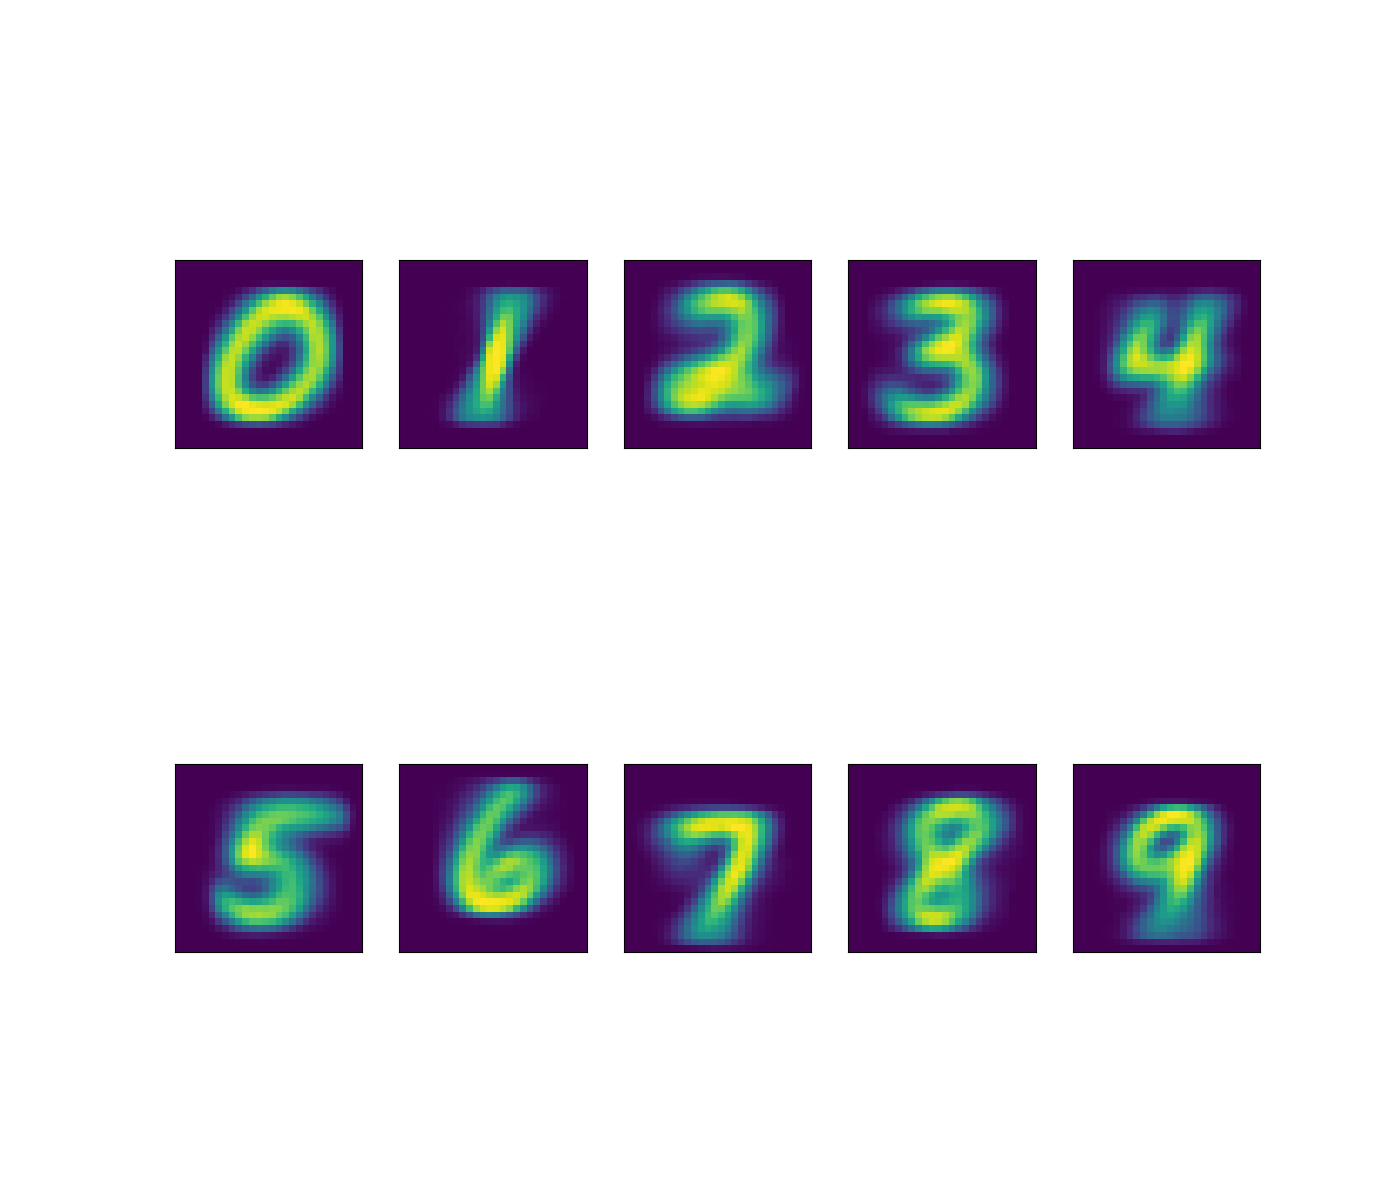

In [104]:

params = nbc.feature_count_
print(params.shape)
fig= plt.figure(figsize=(14,12))
for i in range(2):
    for j in range(5):
        idx = i * 5 + j
        ax = fig.add_subplot(2, 5, idx + 1)
        ax.imshow(params[idx].reshape((28, 28)))
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
       
